In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 4.8 MB/s 
     |████████████████████████████████| 3.5 MB 5.2 MB/s 


In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install --pre deepchem
import deepchem
deepchem.__version__

In [ ]:
import rdkit
import torch
from torch_geometric.datasets import MoleculeNet
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [ ]:
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [ ]:
data.data

Data(x=[14991, 9], edge_index=[2, 30856], edge_attr=[30856, 3], smiles=[1128], y=[1128, 1])

OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 


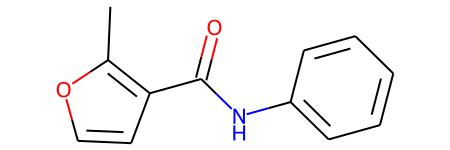

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
print(data[0]["smiles"])
molecule = Chem.MolFromSmiles(data[1]["smiles"])
molecule

In [ ]:
data_t = data[0]
data_t.train_mask = data_t.val_mask = data_t.test_mask = None


In [ ]:
data_t = train_test_split_edges(data_t)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
data_t

Data(x=[32, 9], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1], val_pos_edge_index=[2, 1], val_pos_edge_attr=[1, 3], test_pos_edge_index=[2, 3], test_pos_edge_attr=[3, 3], train_pos_edge_index=[2, 60], train_pos_edge_attr=[60, 3], train_neg_adj_mask=[32, 32], val_neg_edge_index=[2, 1], test_neg_edge_index=[2, 3])

In [ ]:
class GCNEncoder(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super(GCNEncoder, self).__init__()
    self.conv1 = GCNConv(in_channels, out_channels*2, cached = True)
    self.conv2 = GCNConv(out_channels*2, out_channels, cached = True)
  
  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index).relu()
    x = self.conv2(x, edge_index)
    return x

In [ ]:
from torch_geometric.nn import GAE

In [ ]:
# parameters
out_channels = 2
num_features = data.num_features
epochs = 100

# model

model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
x = data_t.x.to(device)
train_pos_edge_index = data_t.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x.float(), train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)

    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x.float(), train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data_t.test_pos_edge_index, data_t.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.7778, AP: 0.8667
Epoch: 002, AUC: 0.7778, AP: 0.8667
Epoch: 003, AUC: 0.7778, AP: 0.8667
Epoch: 004, AUC: 0.7778, AP: 0.8667
Epoch: 005, AUC: 0.7778, AP: 0.8667
Epoch: 006, AUC: 0.7778, AP: 0.8667
Epoch: 007, AUC: 0.7778, AP: 0.8667
Epoch: 008, AUC: 0.7778, AP: 0.8667
Epoch: 009, AUC: 0.7778, AP: 0.8667
Epoch: 010, AUC: 0.7778, AP: 0.8667
Epoch: 011, AUC: 0.7778, AP: 0.8667
Epoch: 012, AUC: 0.7778, AP: 0.8667
Epoch: 013, AUC: 0.7778, AP: 0.8667
Epoch: 014, AUC: 0.7778, AP: 0.8667
Epoch: 015, AUC: 0.7778, AP: 0.8667
Epoch: 016, AUC: 0.7778, AP: 0.8667
Epoch: 017, AUC: 0.7778, AP: 0.8667
Epoch: 018, AUC: 0.7778, AP: 0.8667
Epoch: 019, AUC: 0.7778, AP: 0.8667
Epoch: 020, AUC: 0.7778, AP: 0.8667
Epoch: 021, AUC: 0.7778, AP: 0.8667
Epoch: 022, AUC: 0.7778, AP: 0.8667
Epoch: 023, AUC: 0.7778, AP: 0.8667
Epoch: 024, AUC: 0.7778, AP: 0.8667
Epoch: 025, AUC: 0.7778, AP: 0.8667
Epoch: 026, AUC: 0.7778, AP: 0.8667
Epoch: 027, AUC: 0.7778, AP: 0.8667
Epoch: 028, AUC: 0.7778, AP:

In [ ]:
Z = model.encode(x.float(), train_pos_edge_index)
Z

tensor([[ 0.1233,  0.1606],
        [ 0.1208,  0.1448],
        [ 0.1100,  0.0771],
        [ 0.0990,  0.0080],
        [ 0.0994,  0.0105],
        [ 0.1000,  0.0143],
        [ 0.1038,  0.0380],
        [ 0.1059,  0.0513],
        [ 0.1008,  0.0192],
        [ 0.0992,  0.0090],
        [ 0.0569, -0.2565],
        [ 0.0435, -0.3403],
        [ 0.0345, -0.3969],
        [ 0.0504, -0.2969],
        [ 0.0544, -0.2724],
        [ 0.0674, -0.1904],
        [ 0.0668, -0.1943],
        [ 0.0732, -0.1543],
        [ 0.0717, -0.1633],
        [ 0.0800, -0.1113],
        [ 0.1004,  0.0166],
        [ 0.1072,  0.0594],
        [ 0.1080,  0.0640],
        [ 0.1070,  0.0580],
        [ 0.1094,  0.0728],
        [ 0.1070,  0.0580],
        [ 0.1006,  0.0176],
        [ 0.1072,  0.0594],
        [ 0.1058,  0.0507],
        [ 0.1072,  0.0594],
        [ 0.1056,  0.0493],
        [ 0.1042,  0.0406]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
model.decode(Z,train_pos_edge_index)

tensor([0.5095, 0.5095, 0.5061, 0.5061, 0.5029, 0.5029, 0.5025, 0.5025, 0.5025,
        0.5027, 0.5027, 0.5032, 0.5032, 0.5029, 0.5038, 0.5029, 0.5025, 0.5025,
        0.5025, 0.5224, 0.5224, 0.5341, 0.5238, 0.5341, 0.5299, 0.5299, 0.5238,
        0.5139, 0.5139, 0.5104, 0.5104, 0.5087, 0.5087, 0.5076, 0.5076, 0.5060,
        0.5060, 0.5025, 0.5029, 0.5030, 0.5029, 0.5030, 0.5038, 0.5041, 0.5038,
        0.5038, 0.5041, 0.5040, 0.5040, 0.5025, 0.5030, 0.5029, 0.5030, 0.5029,
        0.5036, 0.5034, 0.5036, 0.5034, 0.5033, 0.5033], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [ ]:
len(x)

32

In [ ]:
len(data_t.smiles)

54